<a href="https://colab.research.google.com/github/ImJongHwan/practice-ml-nlp/blob/main/12_tagging_task/5_Named_Entity_Recognition_using_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)

https://wikidocs.net/147219

## 개체명 인식 데이터에 대한 이해와 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/ner_dataset.csv", filename="ner_dataset.csv")
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [3]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
print(f'데이터프레임 행의 개수: {len(data)}')

데이터프레임 행의 개수: 1048575


In [5]:
print('데이터에 Null 값이 있는지 유무: ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무: True


In [6]:
print('어떤 열에 Null 값이 있는지 출력')
print('=' * 30)
data.isnull().sum()

어떤 열에 Null 값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [7]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [8]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [9]:
data = data.fillna(method='ffill')
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [10]:
print('데이터에 Null 값이 있는지 유무: ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무: False


In [11]:
data.Word = data.Word.str.lower()
print(f'Word 열의 중복을 제거한 값의 개수: {data.Word.nunique()}')

Word 열의 중복을 제거한 값의 개수: 31817


In [12]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [13]:
func = lambda temp: [(w, t) for w, t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]
tagged_sentences = [t for t in data.groupby("Sentence #").apply(func)]
print(f'전체 샘플 개수: {len(tagged_sentences)}')

전체 샘플 개수: 47959


In [14]:
print(tagged_sentences[0])

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [15]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [16]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [17]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


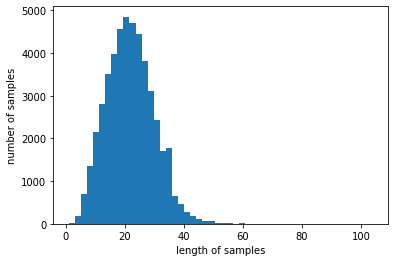

In [18]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 모든 단어를 사용하며 인덱스 1에는 단어 'OOV'를 할당.
src_tokenizer = Tokenizer(oov_token='OOV')
# 태깅 정보들은 내부적으로 대문자를 유지한 채 저장
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [20]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [21]:
print(f'단어 OOV의 인덱스: {src_tokenizer.word_index["OOV"]}')

단어 OOV의 인덱스: 1


In [22]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [23]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [24]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [25]:
decoded = []
for index in X_data[0]:
  decoded.append(index_to_word[index])

print(f'기존의 문장: {sentences[0]}')
print(f'디코딩 문장: {decoded}')

기존의 문장: ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장: ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [26]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [27]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [28]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [29]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


## 양방향 LSTM을 이용한 개체명 인식

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim=128
hidden_units=256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
270/270 [==============================] - 374s 1s/step - loss: 0.1756 - accuracy: 0.8733 - val_loss: 0.0818 - val_accuracy: 0.9273
Epoch 2/6
270/270 [==============================] - 353s 1s/step - loss: 0.0541 - accuracy: 0.9505 - val_loss: 0.0475 - val_accuracy: 0.9544
Epoch 3/6
270/270 [==============================] - 361s 1s/step - loss: 0.0361 - accuracy: 0.9653 - val_loss: 0.0426 - val_accuracy: 0.9585
Epoch 4/6
270/270 [==============================] - 364s 1s/step - loss: 0.0295 - accuracy: 0.9706 - val_loss: 0.0423 - val_accuracy: 0.9593
Epoch 5/6
270/270 [==============================] - 361s 1s/step - loss: 0.0253 - accuracy: 0.9742 - val_loss: 0.0433 - val_accuracy: 0.9592
Epoch 6/6
270/270 [==============================] - 356s 1s/step - loss: 0.0222 - accuracy: 0.9772 - val_loss: 0.0477 - val_accuracy: 0.9581


In [31]:
i = 13
y_predicated = model.predict(np.array([X_test[i]]))
y_predicated = np.argmax(y_predicated, axis=-1)
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word,tag, pred in zip(X_test[i], labels, y_predicated[0]):
  if word != 0:
    print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   O
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


## F1-score

In [32]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels) 
print('예측값 :',predicted)

예측값 : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [33]:
hit = 0 # 정답 개수
for tag, pred in zip(labels, predicted):
    if tag == pred:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(labels) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


In [34]:
pip install seqeval

     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=dd9a52991d92dec82a826815d0cf00cec3ecf120b3dd9270aaf29cf57a9ebd68
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [35]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']

print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



## F1-score로 성능 측정하기

In [37]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences):
  result = []
  for sequence in sequences:
    word_sequence = []
    for pred in sequence:
      pred_index = np.argmax(pred)
      word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
    result.append(word_sequence)
  return result

y_predicated = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicated)
test_tags = sequences_to_tag(y_test)

print(f'F1-score: {f1_score(test_tags, pred_tags):.1%}')
print(classification_report(test_tags, pred_tags))

F1-score: 78.2%
              precision    recall  f1-score   support

         art       0.30      0.05      0.08        63
         eve       0.39      0.27      0.32        52
         geo       0.84      0.82      0.83      7620
         gpe       0.95      0.95      0.95      3145
         nat       0.40      0.22      0.28        37
         org       0.60      0.53      0.56      4033
         per       0.73      0.70      0.71      3545
         tim       0.86      0.84      0.85      4067

   micro avg       0.80      0.76      0.78     22562
   macro avg       0.63      0.55      0.57     22562
weighted avg       0.79      0.76      0.78     22562



# BiLSTM-CRF를 이용한 개체명 인식

## CRF 층 설치하기

In [38]:
pip install keras-crf

     |████████████████████████████████| 1.1 MB 23.6 MB/s 
     |████████████████████████████████| 462 kB 48.5 MB/s 


## BiLSTM-CRF를 이용한 개체명 인식

In [39]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

In [40]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9129 - loss: 29.1784
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.96331, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 125s 429ms/step - decode_sequence_accuracy: 0.9129 - loss: 29.1021 - val_decode_sequence_accuracy: 0.9633 - val_loss: 9.5220
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9725 - loss: 6.4831
Epoch 2: val_decode_sequence_accuracy improved from 0.96331 to 0.97973, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 101s 375ms/step - decode_sequence_accuracy: 0.9725 - loss: 6.4765 - val_decode_sequence_accuracy: 0.9797 - val_loss: 4.8675
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9821 - loss: 3.6812
Epoch 3: val_decode_sequence_accuracy improved from 0.97973 to 0.98265, saving model to bilstm_crf/cp.ckpt
270/270 [=

In [42]:
model.load_weights('bilstm_crf/cp.ckpt')

i = 13
y_predicted = model.predict(np.array([X_test[i]]))[0]
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [43]:
y_predicated = model.predict(X_test)[0]

In [44]:
print(y_predicated[:2])

[[ 1  3 10  1  4  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  3  1  1  1  1  1  1  1  2  9  9  1  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [45]:
def sequences_to_tag_for_crf(sequences):
  result = []
  for sequence in sequences:
    word_sequence  = []
    for pred_index in sequence:
      word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
    result.append(word_sequence)
  return result

pred_tags = sequences_to_tag_for_crf(y_predicated)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 79.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.00      0.00      0.00        52
         geo       0.84      0.83      0.83      7620
         gpe       0.94      0.94      0.94      3145
         nat       0.44      0.11      0.17        37
         org       0.64      0.59      0.61      4033
         per       0.78      0.71      0.74      3545
         tim       0.88      0.81      0.84      4067

   micro avg       0.82      0.77      0.79     22562
   macro avg       0.57      0.50      0.52     22562
weighted avg       0.81      0.77      0.79     22562



# 문자 임베딩(Character Embedding) 활용하기

https://wikidocs.net/147299

## 문자 임베딩(Char Embedding)을 위한 전처리

In [46]:
words = list(set(data["Word"].values))
chars = set(w_i for w in words for w_i in w)
chars = sorted(list(chars))
print('문자 집합: ', chars)

문자 집합:  ['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


In [47]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

index_to_char = {}

for key, value in char_to_index.items():
  index_to_char[value] = key

In [48]:
max_len_char = 15

def padding_char_indice(char_index, max_len_char):
  return pad_sequences(char_index, maxlen=max_len_char, padding='post', value=0)

def integer_coding(sentences):
  char_data = []
  for ts in sentences:
    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t] for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_to_token in char_indice:
      if len(chars_to_token) > max_len_char:
        continue
    
    char_data.append(char_indice)
  return char_data

X_char_data = integer_coding(sentences)

In [49]:
print('기존 문장: ', sentences[0])

기존 문장:  ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [50]:
print('단어 단위 정수 인코딩:')
print(X_data[0])

단어 단위 정수 인코딩:
[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [51]:
# 문자 단위 정수 인코딩
print('문자 단위 정수 인코딩 :')
print(X_char_data[0])

문자 단위 정수 인코딩 :
[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 51 48 46  0  0  0  0

In [52]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value=0)

In [53]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [54]:
print(index_to_word[150])

soldiers


In [55]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


In [56]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


## BiLSTM-CNN을 이용한 개체명 인식

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report
from keras_crf import CRFModel

In [58]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
word_ids = Input(shape=(None,),dtype='int32', name='words_input')
word_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(word_ids)

# char 임베딩
char_ids = Input(shape=(None, max_len_char,), name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_ids)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out = TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='tanh', strides=1))(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char_embeddings = TimeDistributed(Flatten())(maxpool_out)
char_embeddings = Dropout(dropout_ratio)(char_embeddings)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[word_ids, char_ids], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])

In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit([X_train, X_char_train], y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=1, callbacks=[es, mc])

Epoch 1/15
270/270 [==============================] - ETA: 0s - loss: 0.2083 - acc: 0.9480
Epoch 1: val_acc improved from -inf to 0.97708, saving model to bilstm_cnn.h5
270/270 [==============================] - 453s 2s/step - loss: 0.2083 - acc: 0.9480 - val_loss: 0.0826 - val_acc: 0.9771
Epoch 2/15
270/270 [==============================] - ETA: 0s - loss: 0.0635 - acc: 0.9818
Epoch 2: val_acc improved from 0.97708 to 0.98441, saving model to bilstm_cnn.h5
270/270 [==============================] - 442s 2s/step - loss: 0.0635 - acc: 0.9818 - val_loss: 0.0526 - val_acc: 0.9844
Epoch 3/15
270/270 [==============================] - ETA: 0s - loss: 0.0455 - acc: 0.9867
Epoch 3: val_acc improved from 0.98441 to 0.98639, saving model to bilstm_cnn.h5
270/270 [==============================] - 450s 2s/step - loss: 0.0455 - acc: 0.9867 - val_loss: 0.0453 - val_acc: 0.9864
Epoch 4/15
270/270 [==============================] - ETA: 0s - loss: 0.0383 - acc: 0.9885
Epoch 4: val_acc improved from

In [60]:
model = load_model('bilstm_cnn.h5')

i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])

y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경.
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [61]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 79.5%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.70      0.27      0.39        52
         geo       0.84      0.84      0.84      7620
         gpe       0.95      0.95      0.95      3145
         nat       0.48      0.32      0.39        37
         org       0.61      0.57      0.59      4033
         per       0.73      0.74      0.73      3545
         tim       0.87      0.84      0.85      4067

   micro avg       0.80      0.79      0.79     22562
   macro avg       0.65      0.57      0.59     22562
weighted avg       0.80      0.79      0.79     22562



## BiLSTM-CNN-CRF

In [62]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
word_ids = Input(shape=(None,),dtype='int32', name='words_input')
word_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(word_ids)

# char 임베딩
char_ids = Input(shape=(None, max_len_char,), name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_ids)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out = TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char_embeddings = TimeDistributed(Flatten())(maxpool_out)
char_embeddings = Dropout(dropout_ratio)(char_embeddings)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [63]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9361 - loss: 17.8648
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.97157, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 455s 2s/step - decode_sequence_accuracy: 0.9361 - loss: 17.8224 - val_decode_sequence_accuracy: 0.9716 - val_loss: 6.6363
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9801 - loss: 4.4281
Epoch 2: val_decode_sequence_accuracy improved from 0.97157 to 0.98380, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 446s 2s/step - decode_sequence_accuracy: 0.9801 - loss: 4.4232 - val_decode_sequence_accuracy: 0.9838 - val_loss: 3.4418
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9860 - loss: 2.8396
Epoch 3: val_decode_sequence_accuracy improved from 0.98380 to 0.98547, saving model to bilstm_cnn_crf/cp.ckpt
270/

In [64]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')

i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0] 
labels = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [65]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 81.0%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.67      0.27      0.38        52
         geo       0.84      0.86      0.85      7620
         gpe       0.95      0.94      0.95      3145
         nat       0.69      0.24      0.36        37
         org       0.68      0.60      0.64      4033
         per       0.79      0.71      0.75      3545
         tim       0.88      0.85      0.87      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.69      0.56      0.60     22562
weighted avg       0.82      0.79      0.81     22562



## BiLSTM-BiLSTM-CRF

In [66]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

# 단어 임베딩
word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

# char 임베딩
char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

# char 임베딩을 BiLSTM을 통과 시켜 단어 벡터를 얻고 단어 임베딩과 연결
char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Dropout(dropout_ratio)(output)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9229 - loss: 22.7061
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.97379, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 614s 2s/step - decode_sequence_accuracy: 0.9229 - loss: 22.6452 - val_decode_sequence_accuracy: 0.9738 - val_loss: 6.6901
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9810 - loss: 4.4274
Epoch 2: val_decode_sequence_accuracy improved from 0.97379 to 0.98424, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 611s 2s/step - decode_sequence_accuracy: 0.9810 - loss: 4.4265 - val_decode_sequence_accuracy: 0.9842 - val_loss: 3.4949
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9864 - loss: 2.8372
Epoch 3: val_decode_sequence_accuracy improved from 0.98424 to 0.98581, saving model to bilstm_bilstm_crf/cp.

In [67]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')

i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
labels = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [68]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 80.9%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.33      0.02      0.03        63
         eve       0.72      0.25      0.37        52
         geo       0.83      0.87      0.85      7620
         gpe       0.95      0.94      0.95      3145
         nat       0.00      0.00      0.00        37
         org       0.66      0.58      0.62      4033
         per       0.79      0.73      0.76      3545
         tim       0.87      0.85      0.86      4067

   micro avg       0.82      0.80      0.81     22562
   macro avg       0.65      0.53      0.55     22562
weighted avg       0.81      0.80      0.80     22562

